In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

In [2]:
from pyldl.utils import encode_one_hot, kullback_leibler_divergence, load_usps, contingency_matrix
from pyldl.encapsulations import AutoEncoder, Sequential
from pyldl.modules import Linear
from pyldl.losses import BCELoss, MSELoss, CrossEntropyLoss
from pyldl.activations import Sigmoid, Tanh, Softmax
from pyldl.optimizers import SGD

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np

In [3]:
np.random.seed(0)

In [4]:
def add_noise(data, sigma=0.05):
    return data + sigma*np.random.randn(*data.shape) 

## Loading the Dataset

In [5]:
digits = load_digits()

X = digits.data

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_noise = add_noise(X)

X_train, X_test, y_train, y_test = train_test_split(X_noise, X, test_size=0.2)

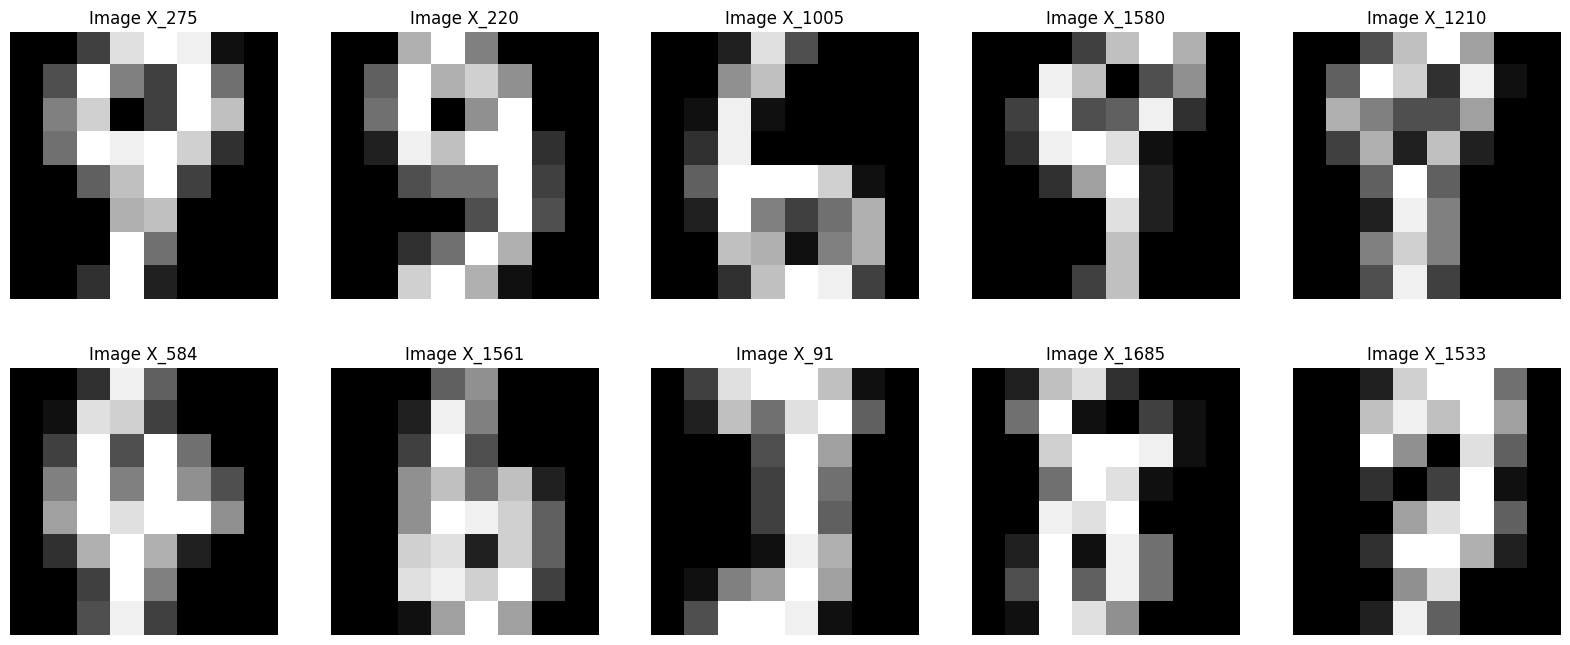

In [6]:
n_images = 10
random_indexes = np.random.choice(range(len(X)), n_images)
images = X[random_indexes]

plt.subplots(2, 5, figsize=(20, 8))
for i in range(n_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Image X_{random_indexes[i]}")
    plt.axis('off')
plt.show()

## Autoencoder and Reconstruction

In [7]:
encoder = Sequential(
    Linear(X_train.shape[1], 32), 
    Tanh(),
    Linear(32, 16),
    Tanh(),
    Linear(16, 2),
    Tanh(),
)

decoder = Sequential(
    Linear(2, 16),
    Tanh(),
    Linear(16, 32),
    Tanh(),
    Linear(32, X_train.shape[1]),
    Sigmoid()
)

autoencoder = AutoEncoder(encoder, decoder)

In [8]:
losses = SGD(autoencoder, MSELoss(), X_train, y_train, batch_size=32, gradient_step=1e-3, n_iter=1000)

100%|██████████| 1000/1000 [00:15<00:00, 64.61it/s]


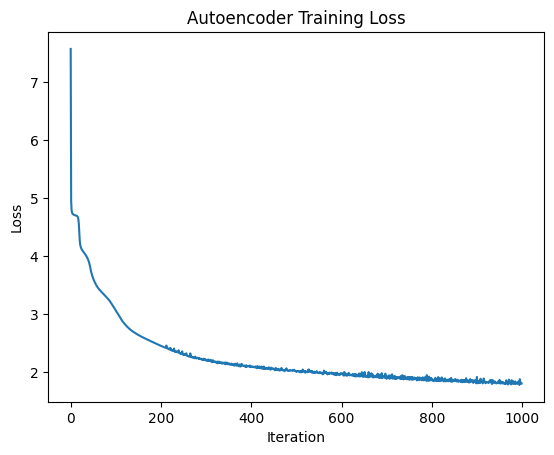

In [9]:
plt.plot(losses)
plt.title("Autoencoder Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [10]:
yhat = autoencoder(X_test)
print("Score: ", kullback_leibler_divergence(yhat, y_test))

Score:  32.84315402970855


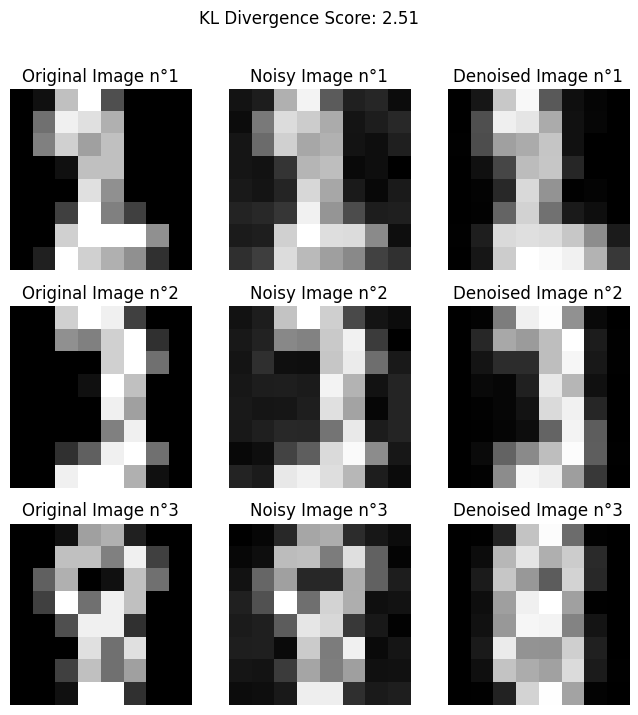

In [11]:
n_images = 3

random_indexes = np.random.choice(range(len(X_test)), n_images)
original_images = y_test[random_indexes]
noisy_images = X_test[random_indexes]
denoised_images = autoencoder(noisy_images)

plt.subplots(3, 3, figsize=(8, 8))
plt.suptitle(f"KL Divergence Score: {kullback_leibler_divergence(original_images, denoised_images):.2f}")


for i in range(n_images):
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(original_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Original Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 3, 3*i+2)
    plt.imshow(noisy_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Noisy Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 3, 3*i+3)
    plt.imshow(denoised_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Denoised Image n°{i+1}")
    plt.axis('off')
plt.show()

## Accuracy using noised and denoised images

In [12]:
digits = load_digits()

X = digits.data

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train_one_hot = encode_one_hot(y_train)
y_test_one_hot = encode_one_hot(y_test)



In [13]:
network = Sequential(Linear(X_train.shape[1], 128), Sigmoid(), Linear(128, 64), Sigmoid(), Linear(64, y_train_one_hot.shape[1]))
loss = CrossEntropyLoss()

In [14]:
losses = SGD(network, loss, X_train, y_train_one_hot, batch_size=64, gradient_step=1e-3, n_iter=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:14<00:00, 67.96it/s]


In [15]:
def predict(X):
    return network(X).argmax(axis=1)

def accuracy(y, yhat):
    return (y == yhat).mean()

yhat = predict(X_test)
print(f"Accuracy: {accuracy(y_test, yhat)*100:.2f}%")

yhat_noise = predict(X_noise)
print(f"Accuracy using noised images: {accuracy(y, yhat_noise)*100:.2f}%")

yhat_denoise = predict(autoencoder(X_noise))
print(f"Accuracy using denoised images: {accuracy(y, yhat_denoise)*100:.2f}%")


Accuracy: 97.22%
Accuracy using noised images: 98.22%
Accuracy using denoised images: 87.42%


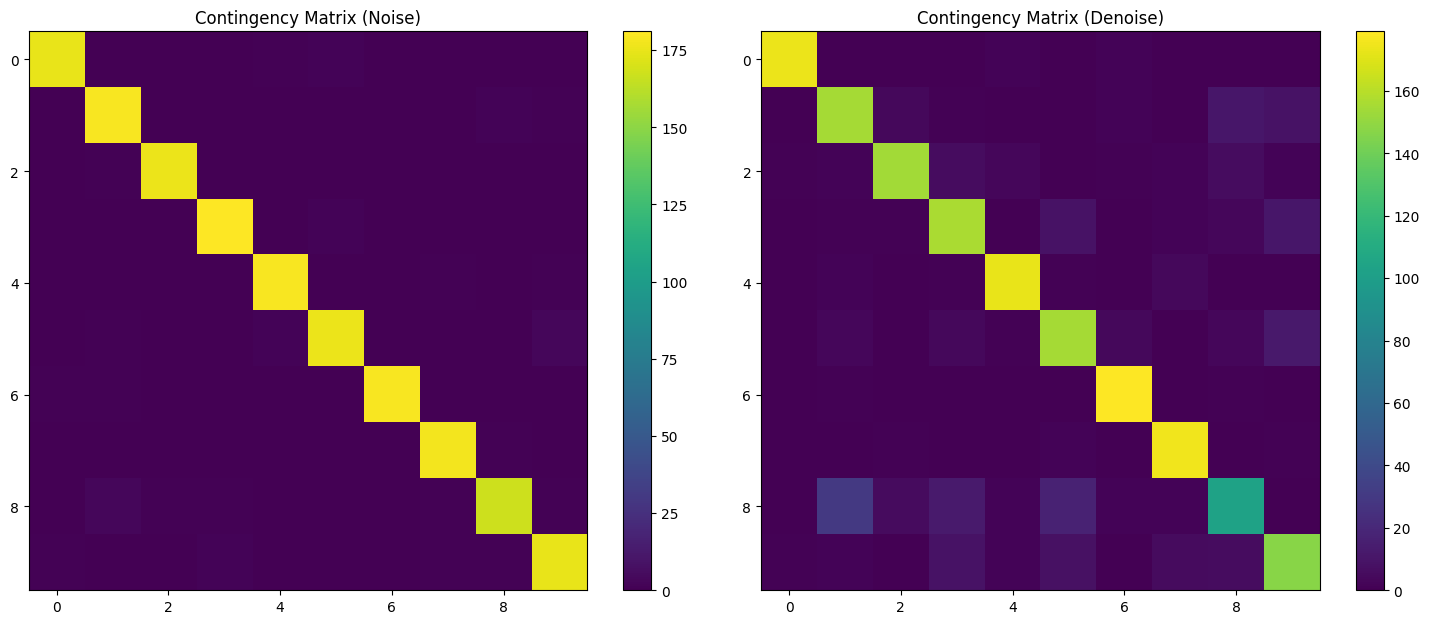

In [16]:
# Calculate contingency matrices
m_noise = contingency_matrix(y, yhat_noise)
m_denoise = contingency_matrix(y, yhat_denoise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting contingency matrix for yhat_noise
axs[0].imshow(m_noise)
axs[0].set_title("Contingency Matrix (Noise)")
plt.colorbar(axs[0].imshow(m_noise), ax=axs[0])

# Plotting contingency matrix for yhat_denoise
axs[1].imshow(m_denoise)
axs[1].set_title("Contingency Matrix (Denoise)")
plt.colorbar(axs[1].imshow(m_denoise), ax=axs[1])

plt.tight_layout()
plt.show()


## Network Optimization

In [17]:
from itertools import product

def grid_search(X_train, X_test, y_train, y_test, params):
    best_score = np.inf
    best_model = None
    best_params = None
    best_losses = None
    for activation, batch_size, gradient_step, loss, n_epochs, n_neurons_per_layer in product(*params.values()):
        encoder_layers, decoder_layers = [], []
        for i in range(len(n_neurons_per_layer)-1):
            encoder_layers += [Linear(n_neurons_per_layer[i], n_neurons_per_layer[i+1]), activation()]
            decoder_layers = [Linear(n_neurons_per_layer[i+1], n_neurons_per_layer[i]), activation()] + decoder_layers
        autoencoder = AutoEncoder(Sequential(*encoder_layers), Sequential(*decoder_layers))
        losses = SGD(autoencoder, loss(), X_train, y_train, batch_size=batch_size, gradient_step=gradient_step, n_iter=n_epochs)
        # reconstructed_images = autoencoder(X_test)
        score = losses[-1]
        if score < best_score:
            best_model = autoencoder
            best_score = score
            best_losses = losses
            best_params = {
                "activation_functions": activation.__name__,
                "batch_size": batch_size,
                "gradient_step": gradient_step,
                "loss": loss.__name__,
                "n_epochs": n_epochs,
                "n_neurons_per_layer": n_neurons_per_layer,
            }
    return best_model, best_params, best_score, best_losses

In [18]:
digits = load_digits()

X = digits.data

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_noise = add_noise(X)

X_train, X_test, y_train, y_test = train_test_split(X_noise, X, test_size=0.2)

In [19]:
# params = {
#     "activation_functions": [Sigmoid, Tanh],
#     "batch_size": [32, 64, 128],
#     "gradient_step": [0.01, 0.001, 0.0001],
#     "loss": [BCELoss, MSELoss],
#     "n_epochs": [500, 1000, 2000],
#     "n_neurons_per_layer": [[X_noise.shape[1], 64], [X_noise.shape[1], 64, 32], [X_noise.shape[1], 64, 32, 16]],
# }

params = {
    "activation_functions": [Tanh],
    "batch_size": [32],
    "gradient_step": [0.001],
    "loss": [MSELoss],
    "n_epochs": [1000],
    "n_neurons_per_layer": [[X_train.shape[1], 32, 16, 2]],
}

best_model, best_params, best_score, best_losses = grid_search(X_train, X_test, y_train, y_test, params)

100%|██████████| 1000/1000 [00:16<00:00, 60.21it/s]


In [20]:
print("Best parameters: ", best_params)

Best parameters:  {'activation_functions': 'Tanh', 'batch_size': 32, 'gradient_step': 0.001, 'loss': 'MSELoss', 'n_epochs': 1000, 'n_neurons_per_layer': [64, 32, 16, 2]}


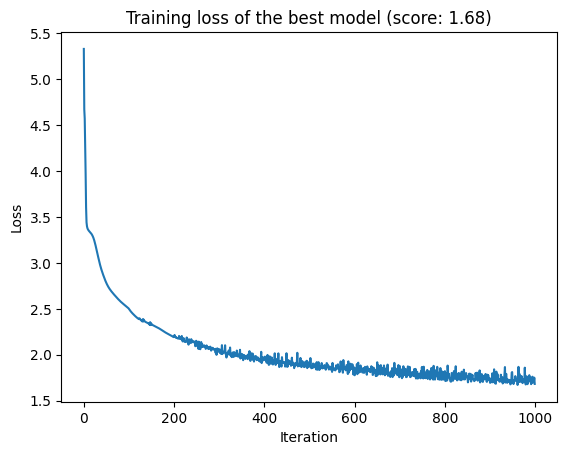

In [21]:
plt.plot(best_losses)
plt.title(f"Training loss of the best model (score: {best_score:.2f})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

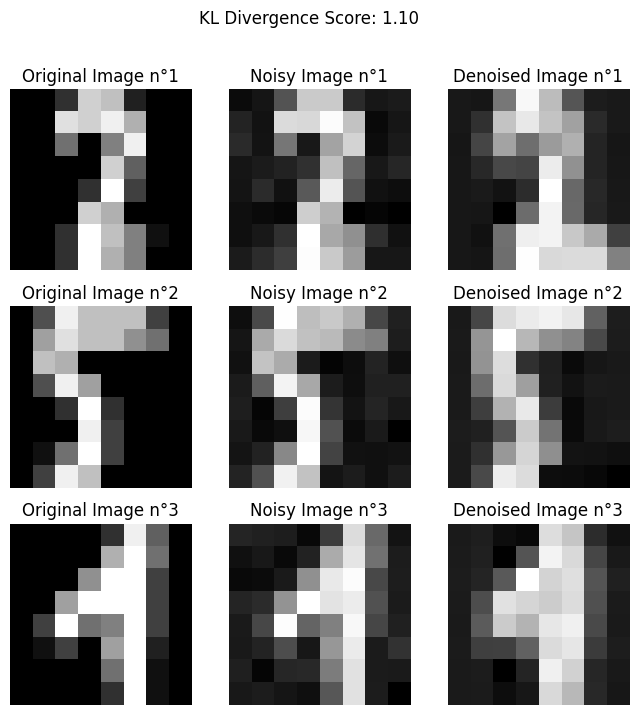

In [22]:
n_images = 3

random_indexes = np.random.choice(range(len(X_test)), n_images)
original_images = y_test[random_indexes]
noisy_images = X_test[random_indexes]
denoised_images = best_model(noisy_images)

plt.subplots(3, 3, figsize=(8, 8))
plt.suptitle(f"KL Divergence Score: {kullback_leibler_divergence(original_images, denoised_images):.2f}")


for i in range(n_images):
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(original_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Original Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 3, 3*i+2)
    plt.imshow(noisy_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Noisy Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 3, 3*i+3)
    plt.imshow(denoised_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Denoised Image n°{i+1}")
    plt.axis('off')
plt.show()

## Accuracy using noised and denoised images

In [23]:
digits = load_digits()

X = digits.data

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train_one_hot = encode_one_hot(y_train)
y_test_one_hot = encode_one_hot(y_test)

network = Sequential(Linear(X_train.shape[1], 128), Sigmoid(), Linear(128, 64), Sigmoid(), Linear(64, y_train_one_hot.shape[1]))
loss = CrossEntropyLoss()

losses = SGD(network, loss, X_train, y_train_one_hot, batch_size=64, gradient_step=1e-3, n_iter=1000)

yhat = predict(X_test)
print(f"Accuracy: {accuracy(y_test, yhat)*100:.2f}%")

yhat_noise = predict(X_noise)
print(f"Accuracy using noised images: {accuracy(y, yhat_noise)*100:.2f}%")

yhat_denoise = predict(best_model(X_noise))
print(f"Accuracy using denoised images: {accuracy(y, yhat_denoise)*100:.2f}%")


100%|██████████| 1000/1000 [00:14<00:00, 67.63it/s]

Accuracy: 97.50%
Accuracy using noised images: 98.33%
Accuracy using denoised images: 91.60%


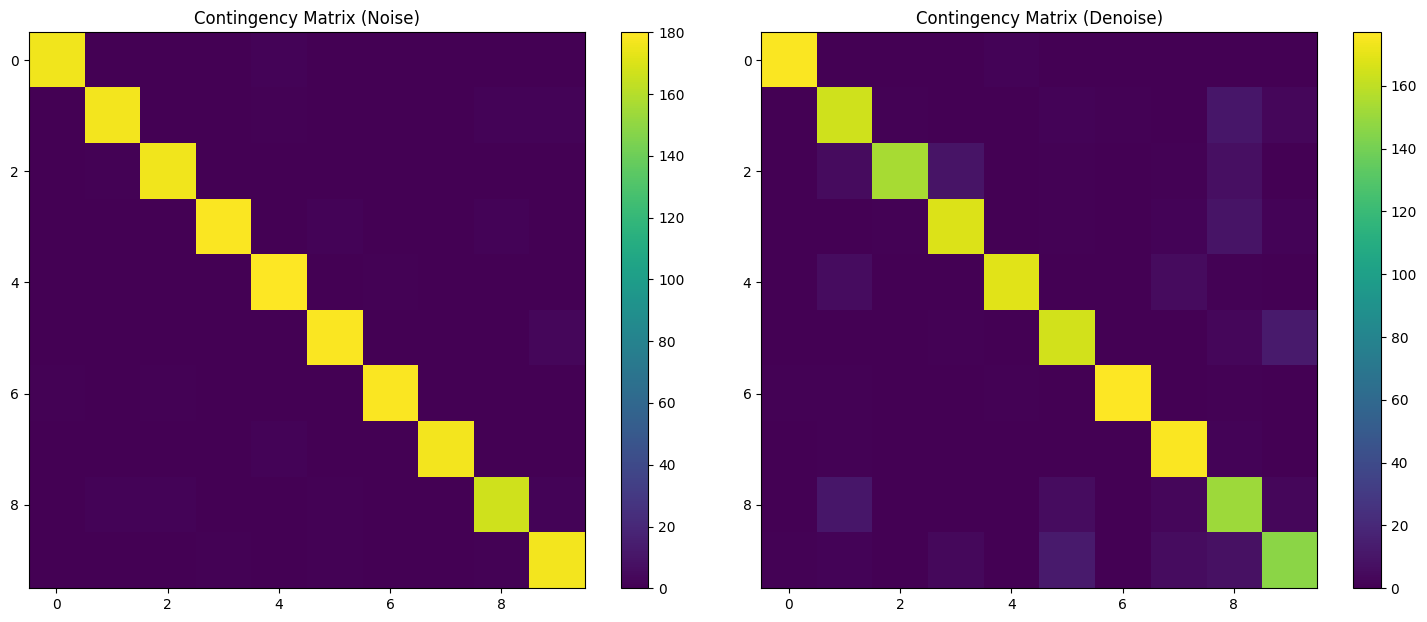

In [24]:
# Calculate contingency matrices
m_noise = contingency_matrix(y, yhat_noise)
m_denoise = contingency_matrix(y, yhat_denoise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting contingency matrix for yhat_noise
axs[0].imshow(m_noise)
axs[0].set_title("Contingency Matrix (Noise)")
plt.colorbar(axs[0].imshow(m_noise), ax=axs[0])

# Plotting contingency matrix for yhat_denoise
axs[1].imshow(m_denoise)
axs[1].set_title("Contingency Matrix (Denoise)")
plt.colorbar(axs[1].imshow(m_denoise), ax=axs[1])

plt.tight_layout()
plt.show()

## Testing on another Dataset

In [25]:
X, _ = load_usps("../data/USPS_data.txt")

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_noise = add_noise(X)

X_train, X_test, y_train, y_test = train_test_split(X_noise, X, test_size=0.2)

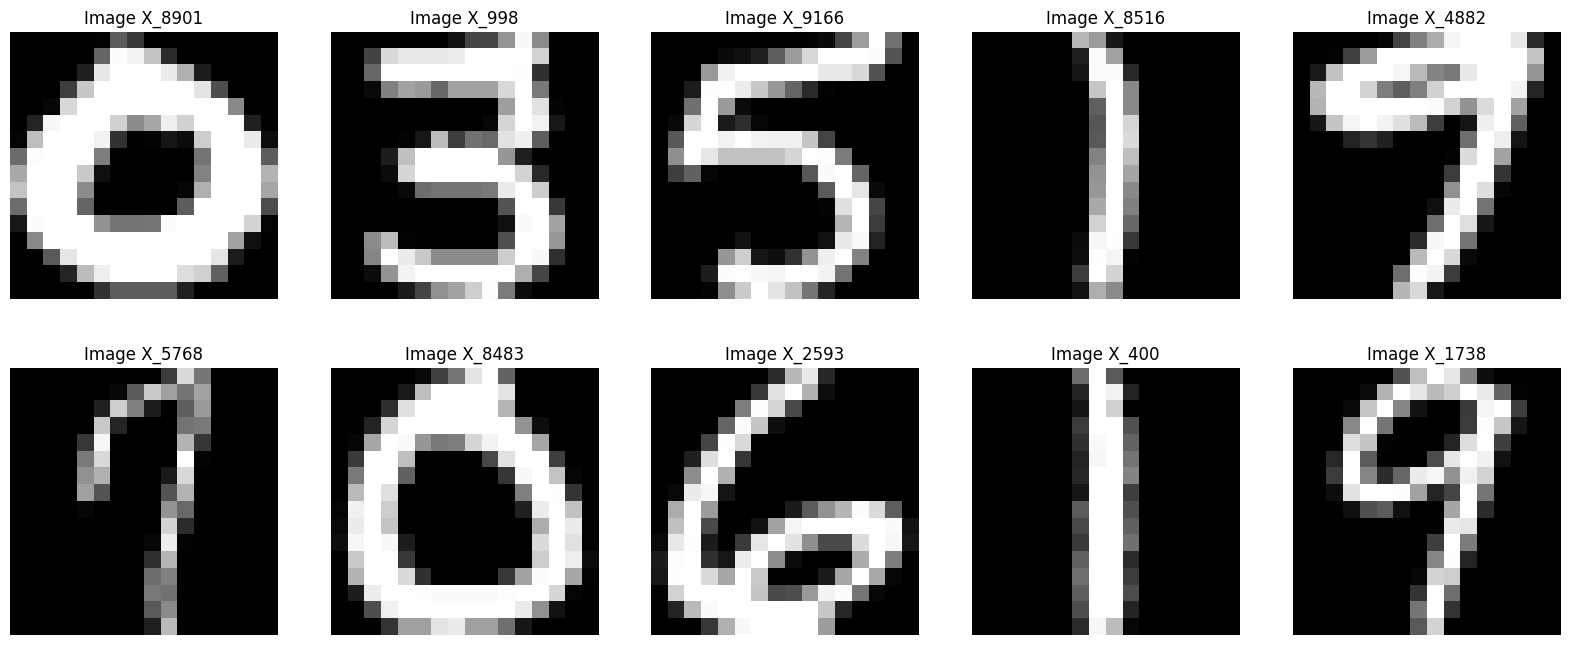

In [26]:
n_images = 10
random_indexes = np.random.choice(range(len(X)), n_images)
images = X[random_indexes]

plt.subplots(2, 5, figsize=(20, 8))
for i in range(n_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Image X_{random_indexes[i]}")
    plt.axis('off')
plt.show()

In [27]:
params = {
    "activation_functions": [Tanh],
    "batch_size": [32],
    "gradient_step": [0.001],
    "loss": [MSELoss],
    "n_epochs": [100],
    "n_neurons_per_layer": [[X_train.shape[1], 128, 64, 32]],
}

best_model, best_params, best_score, best_losses = grid_search(X_train, X_test, y_train, y_test, params)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


In [28]:
print("Best parameters: ", best_params)

Best parameters:  {'activation_functions': 'Tanh', 'batch_size': 32, 'gradient_step': 0.001, 'loss': 'MSELoss', 'n_epochs': 100, 'n_neurons_per_layer': [256, 128, 64, 32]}


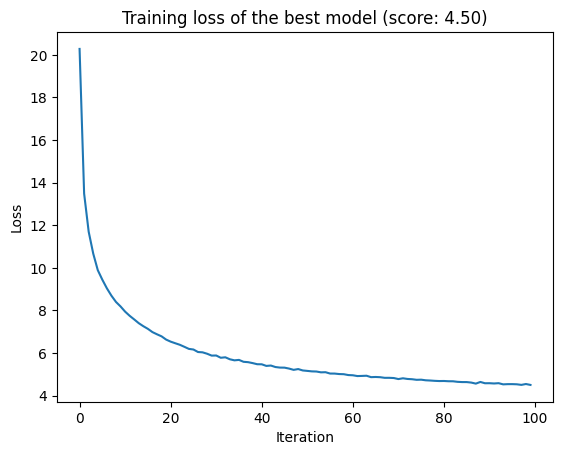

In [29]:
plt.plot(best_losses)
plt.title(f"Training loss of the best model (score: {best_score:.2f})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

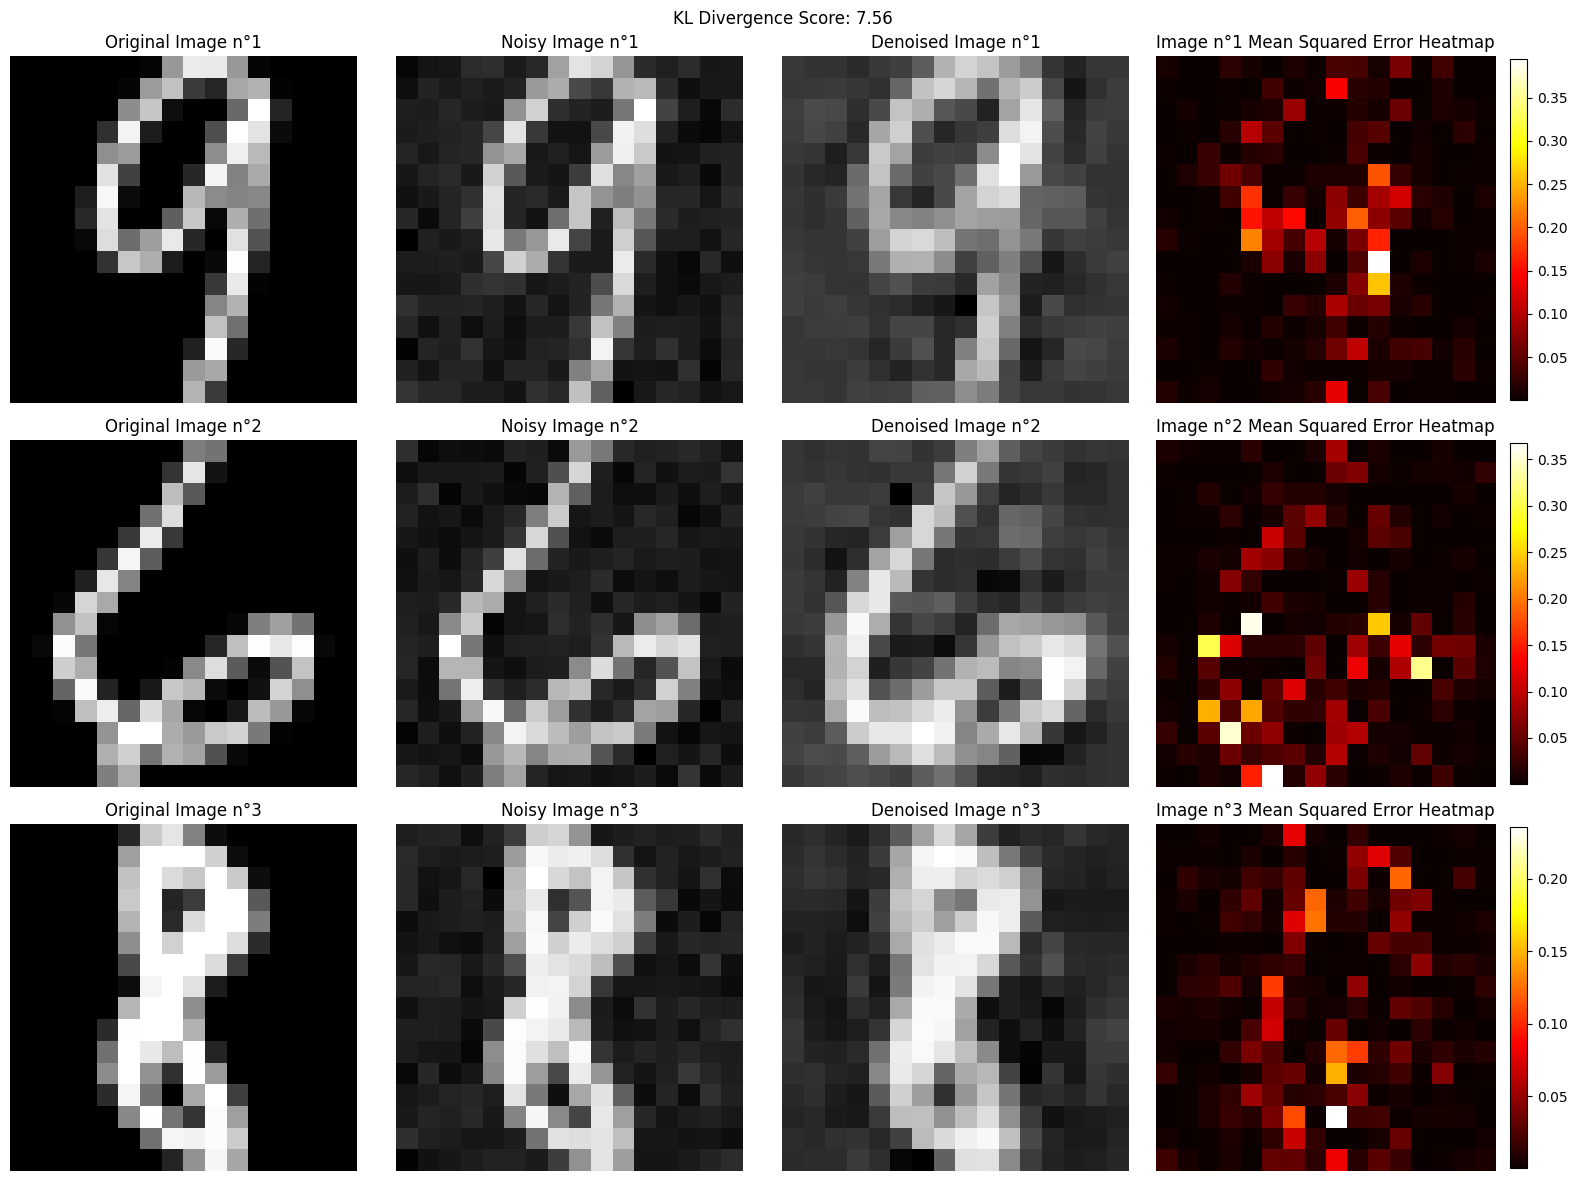

In [30]:
n_images = 3

random_indexes = np.random.choice(range(len(X_test)), n_images)
original_images = y_test[random_indexes]
noisy_images = X_test[random_indexes]
denoised_images = best_model(noisy_images)

plt.figure(figsize=(16, 4 * n_images))
plt.suptitle(f"KL Divergence Score: {kullback_leibler_divergence(original_images, denoised_images):.2f}")


for i in range(n_images):
    # Plot original image
    plt.subplot(n_images, 4, 4 * i + 1)
    plt.imshow(original_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Original Image n°{i+1}")
    plt.axis('off')

    # Plot noisy image
    plt.subplot(n_images, 4, 4 * i + 2)
    plt.imshow(noisy_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Noisy Image n°{i+1}")
    plt.axis('off')

    # Plot denoised image
    plt.subplot(n_images, 4, 4 * i + 3)
    plt.imshow(denoised_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Denoised Image n°{i+1}")
    plt.axis('off')

    # Calculate and plot the heatmap
    mse_images = (noisy_images[i] - denoised_images[i])**2
    heatmap_data = mse_images.reshape(16, 16)
    plt.subplot(n_images, 4, 4 * (i + 1))
    heatmap = plt.imshow(heatmap_data, cmap='hot', aspect='auto')
    plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    plt.title(f'Image n°{i+1} Mean Squared Error Heatmap')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [31]:
X, y = load_usps("../data/USPS_data.txt")

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train_one_hot = encode_one_hot(y_train)
y_test_one_hot = encode_one_hot(y_test)

network = Sequential(Linear(X_train.shape[1], 128), Sigmoid(), Linear(128, 64), Sigmoid(), Linear(64, y_train_one_hot.shape[1]))
loss = CrossEntropyLoss()

losses = SGD(network, loss, X_train, y_train_one_hot, batch_size=64, gradient_step=1e-3, n_iter=1000)

100%|██████████| 1000/1000 [01:30<00:00, 11.06it/s]


In [32]:
yhat = predict(X_test)
print(f"Accuracy: {accuracy(y_test, yhat)*100:.2f}%")

yhat_noise = predict(X_noise)
print(f"Accuracy using noised images: {accuracy(y, yhat_noise)*100:.2f}%")

yhat_denoise = predict(best_model(X_noise))
print(f"Accuracy using denoised images: {accuracy(y, yhat_denoise)*100:.2f}%")

Accuracy: 96.56%
Accuracy using noised images: 99.31%
Accuracy using denoised images: 97.23%


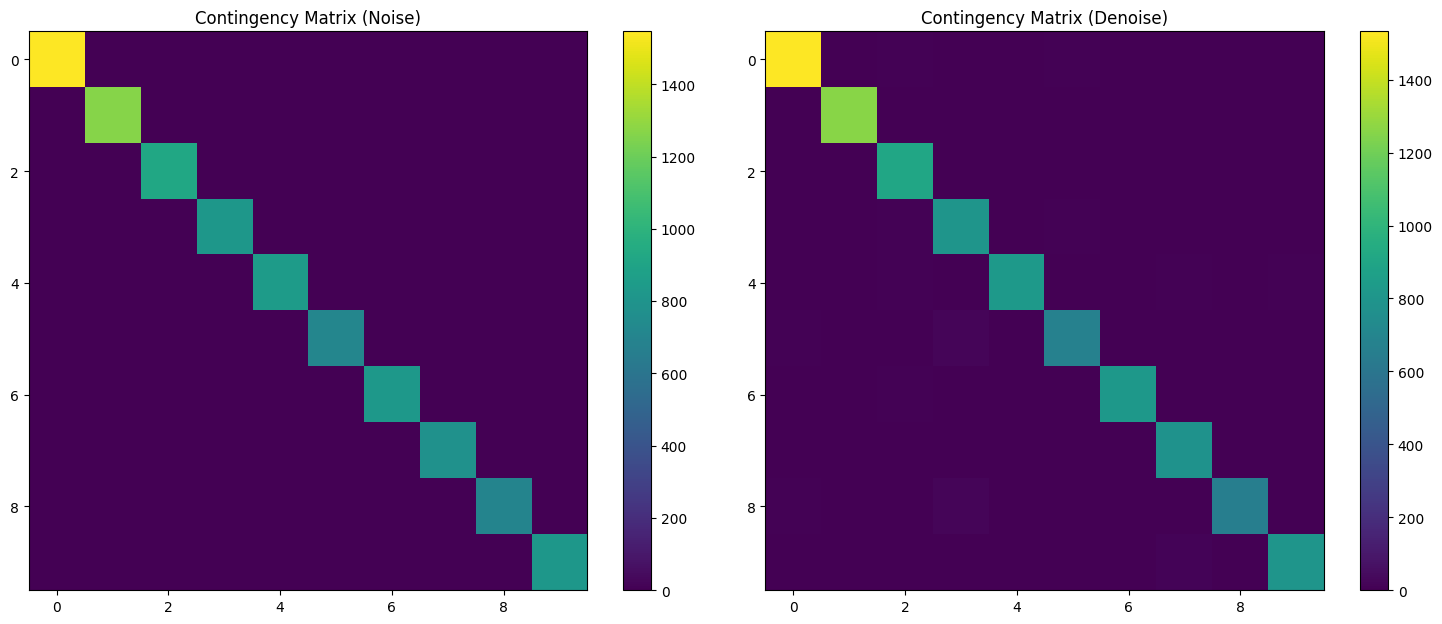

In [33]:
# Calculate contingency matrices
m_noise = contingency_matrix(y, yhat_noise)
m_denoise = contingency_matrix(y, yhat_denoise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting contingency matrix for yhat_noise
axs[0].imshow(m_noise)
axs[0].set_title("Contingency Matrix (Noise)")
plt.colorbar(axs[0].imshow(m_noise), ax=axs[0])

# Plotting contingency matrix for yhat_denoise
axs[1].imshow(m_denoise)
axs[1].set_title("Contingency Matrix (Denoise)")
plt.colorbar(axs[1].imshow(m_denoise), ax=axs[1])

plt.tight_layout()
plt.show()

# Bceloss


In [34]:
X, _ = load_usps("../data/USPS_data.txt")

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_noise = add_noise(X)

X_train, X_test, y_train, y_test = train_test_split(X_noise, X, test_size=0.2)

In [35]:
params = {
    "activation_functions": [Sigmoid],
    "batch_size": [32],
    "gradient_step": [0.1],
    "loss": [BCELoss],
    "n_epochs": [100],
    "n_neurons_per_layer": [[X_train.shape[1], 100, 10]],
}

best_model, best_params, best_score, best_losses = grid_search(X_train, X_test, y_train, y_test, params)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:23<00:00,  4.17it/s]


In [36]:
print("Best parameters: ", best_params)

Best parameters:  {'activation_functions': 'Sigmoid', 'batch_size': 32, 'gradient_step': 0.1, 'loss': 'BCELoss', 'n_epochs': 100, 'n_neurons_per_layer': [256, 100, 10]}


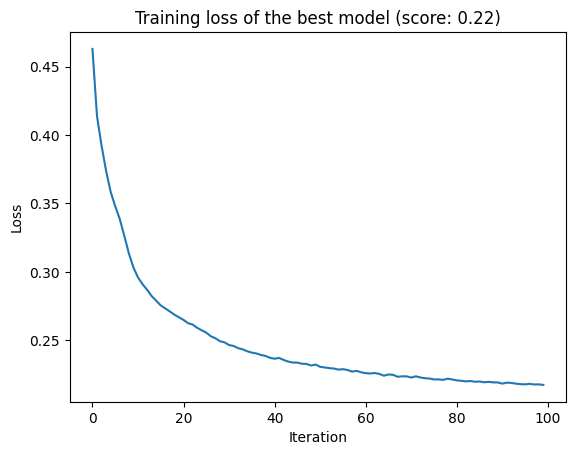

[0.46290327903235656, 0.4137205233442827, 0.3921854259642806, 0.37369739901865284, 0.35836973003346423, 0.3478943096110011, 0.33852316574867686, 0.3261772759310588, 0.31337056090755044, 0.3031501143235567, 0.29583593398536684, 0.29091521404211945, 0.2868499257378781, 0.28224826845418377, 0.2788308418810704, 0.2753840561157427, 0.27319795486301185, 0.2709585010362479, 0.2686406093261952, 0.26670012174151986, 0.26482151733201864, 0.2624081891450411, 0.2614135540829693, 0.2590280743668431, 0.2572059110442421, 0.255529783624383, 0.252856347777484, 0.2514209820001136, 0.24925736864325057, 0.2484282481793498, 0.2464468859304444, 0.24577418214771768, 0.24413468581292114, 0.24328944774098438, 0.24187655032925726, 0.2409193787009204, 0.2403171151756599, 0.2391872655234148, 0.23850314531493852, 0.23707844333515002, 0.23648285913239972, 0.2370232961177491, 0.23552928076505192, 0.23434869844123862, 0.23366244709840225, 0.23362487783170266, 0.23278621990505907, 0.23264125991476337, 0.23148158838536

In [37]:
plt.plot(best_losses)
plt.title(f"Training loss of the best model (score: {best_score:.2f})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()
print(best_losses)

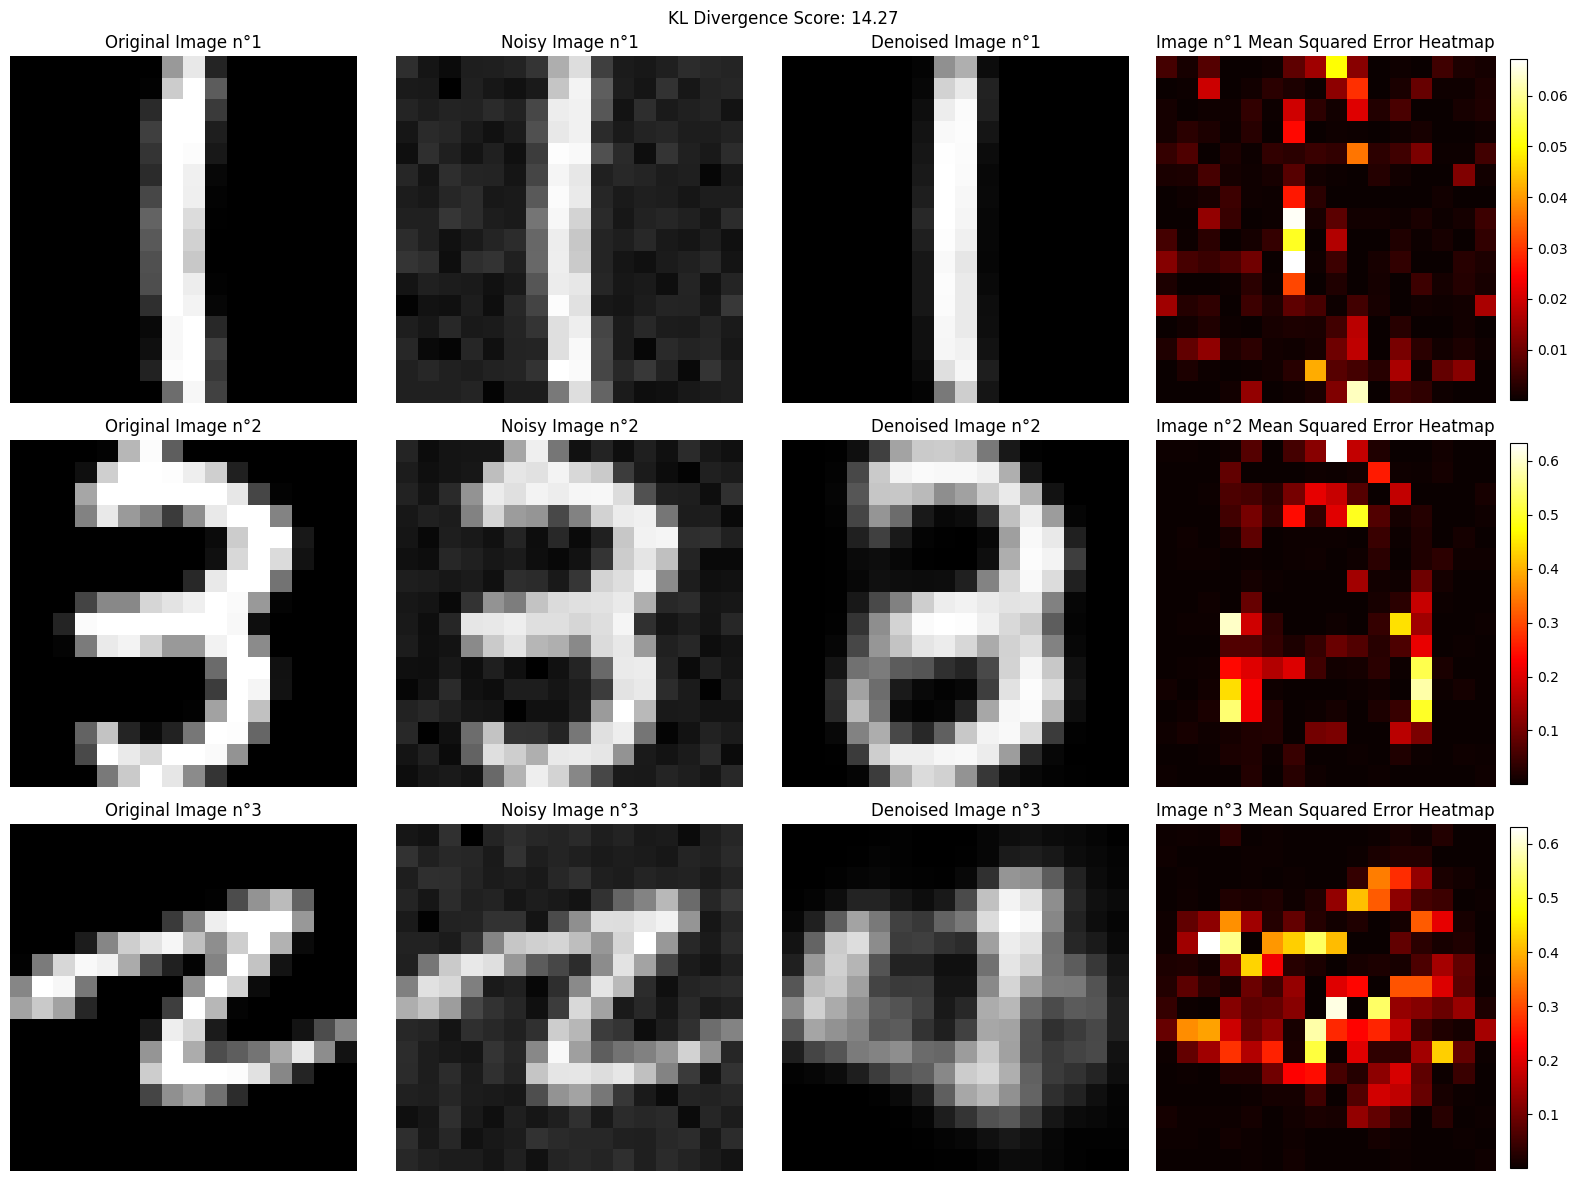

In [38]:
n_images = 3

random_indexes = np.random.choice(range(len(X_test)), n_images)
original_images = y_test[random_indexes]
noisy_images = X_test[random_indexes]
denoised_images = best_model(noisy_images)

plt.figure(figsize=(16, 4 * n_images))
plt.suptitle(f"KL Divergence Score: {kullback_leibler_divergence(original_images, denoised_images):.2f}")

for i in range(n_images):
    # Plot original image
    plt.subplot(n_images, 4, 4 * i + 1)
    plt.imshow(original_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Original Image n°{i+1}")
    plt.axis('off')

    # Plot noisy image
    plt.subplot(n_images, 4, 4 * i + 2)
    plt.imshow(noisy_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Noisy Image n°{i+1}")
    plt.axis('off')

    # Plot denoised image
    plt.subplot(n_images, 4, 4 * i + 3)
    plt.imshow(denoised_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Denoised Image n°{i+1}")
    plt.axis('off')

    # Calculate and plot the heatmap
    mse_images = (noisy_images[i] - denoised_images[i])**2
    heatmap_data = mse_images.reshape(16, 16)
    plt.subplot(n_images, 4, 4 * (i + 1))
    heatmap = plt.imshow(heatmap_data, cmap='hot', aspect='auto')
    plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    plt.title(f'Image n°{i+1} Mean Squared Error Heatmap')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [39]:
X, y = load_usps("../data/USPS_data.txt")

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train_one_hot = encode_one_hot(y_train)
y_test_one_hot = encode_one_hot(y_test)

network = Sequential(Linear(X_train.shape[1], 128), Sigmoid(), Linear(128, 64), Sigmoid(), Linear(64, y_train_one_hot.shape[1]))
loss = CrossEntropyLoss()

losses = SGD(network, loss, X_train, y_train_one_hot, batch_size=64, gradient_step=1e-3, n_iter=1000)

100%|██████████| 1000/1000 [01:32<00:00, 10.75it/s]


In [40]:
yhat = predict(X_test)
print(f"Accuracy: {accuracy(y_test, yhat)*100:.2f}%")

yhat_noise = predict(X_noise)
print(f"Accuracy using noised images: {accuracy(y, yhat_noise)*100:.2f}%")

yhat_denoise = predict(best_model(X_noise))
print(f"Accuracy using denoised images: {accuracy(y, yhat_denoise)*100:.2f}%")

Accuracy: 96.51%
Accuracy using noised images: 99.29%
Accuracy using denoised images: 92.20%


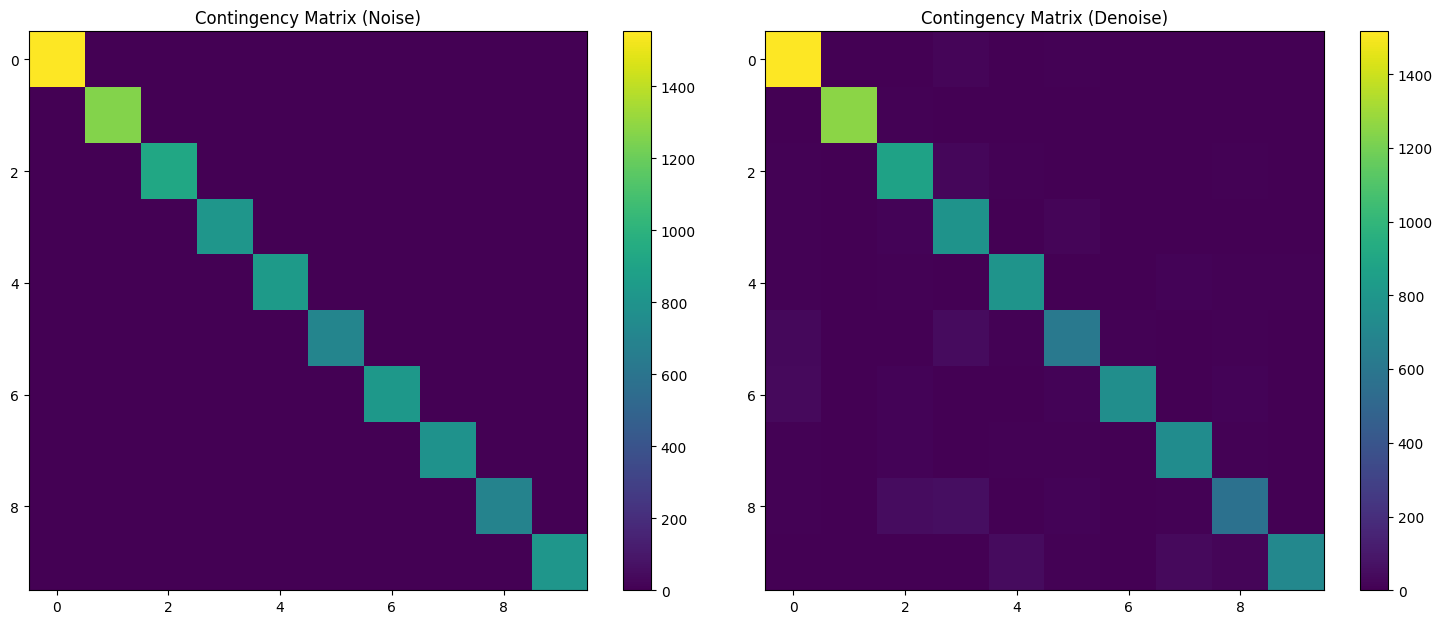

In [41]:
# Calculate contingency matrices
m_noise = contingency_matrix(y, yhat_noise)
m_denoise = contingency_matrix(y, yhat_denoise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting contingency matrix for yhat_noise
axs[0].imshow(m_noise)
axs[0].set_title("Contingency Matrix (Noise)")
plt.colorbar(axs[0].imshow(m_noise), ax=axs[0])

# Plotting contingency matrix for yhat_denoise
axs[1].imshow(m_denoise)
axs[1].set_title("Contingency Matrix (Denoise)")
plt.colorbar(axs[1].imshow(m_denoise), ax=axs[1])

plt.tight_layout()
plt.show()